In [1]:
#ライブラリのインストール（追加：形態素解析Sudachi）
!pip install sudachipy sudachidict_core

     |████████████████████████████████| 2.2 MB 12.6 MB/s 
  Created wheel for sudachidict-core: filename=SudachiDict_core-20211220-py3-none-any.whl size=71565353 sha256=87e19d315347e302062e9c3636ae3621eaeef498cae8eb15adeb5a5748056eac
  Stored in directory: /root/.cache/pip/wheels/17/6d/f6/f9451cbfc76ffdf985af12239191ca20721f1da5aba5005eb0
Successfully built sudachidict-core


In [2]:
#ライブラリのバージョン確認
!pip show sortedcontainers

Name: sortedcontainers
Version: 2.4.0
Summary: Sorted Containers -- Sorted List, Sorted Dict, Sorted Set
Home-page: http://www.grantjenks.com/docs/sortedcontainers/
Author: Grant Jenks
Author-email: contact@grantjenks.com
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: intervaltree, distributed


In [3]:
#datasetダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar xzf ldcc-20140209.tar.gz

--2022-03-02 22:40:59--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  1.87MB/s    in 5.5s    

2022-03-02 22:41:06 (1.53 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]



In [4]:
#datasetの準備
import os

# テキスト直下のディレクトリ一覧を取得(これがカテゴリになる。)
dirlist = os.listdir('text')
category_list = {}
i=0
for dirname in dirlist:
    if dirname[-3:] != 'txt':
        category_list[str(i)] = dirname
        i+=1

# データセットを作成して、ファイルに出力する。tsv形式で、ファイル名、ラベルid、カテゴリ名、テキストを出力する。
with open('dataset.tsv', 'w') as f_out:
    for label, category in category_list.items():
        path = './text/{}/'.format(category)
        filelist = os.listdir(path)
        filelist.remove('LICENSE.txt')
        for filename in filelist:
            with open(path + filename, 'r') as f_in:
                # テキストはタイトルのみ取得　(本文は学習対象にしない)
                text = f_in.readlines()[2]
                # カラム生成
                out_row = [filename, label, category, text]
                f_out.write("\t".join(out_row))

In [5]:
#dataset.tsvをpandasでロード
import pandas as pd
df = pd.read_table(
    'dataset.tsv',
    names=['filename', 'label', 'category', 'text']
    ).sample(frac=1, random_state=0).reset_index(drop=True)

In [6]:
# データを学習:テスト用=8:2に分割
N = len(df)
train_df = df[:int(N * 0.8)] # 学習
test_df = df[int(N * 0.8):] # テスト

In [7]:
#ベースライン決定
from unicodedata import normalize
from sudachipy import tokenizer
from sudachipy import dictionary
import string

from sklearn.feature_extraction.text import CountVectorizer

# 前処理
class TextPreprocessing(object):
    def __init__(self):
        self.tokenizer_obj = dictionary.Dictionary().create()
        self.mode = tokenizer.Tokenizer.SplitMode.A
        self.vectorizer = CountVectorizer()

    # テキストに対して前処理を実施
    def _preprocess(self, text):
        # トークン化
        morphs = []
        for m in self.tokenizer_obj.tokenize(text, self.mode):
            morphs.append(m.surface())

        return " ".join(morphs)

    # 文章データの行列を生成(各文章に対するベクトル一覧)
    def get_matrix(self, text_series, mode='train'):
        text_series = text_series.map(self._preprocess)

        if mode == 'train':
            # 辞書作成と文章データの行列を作成
            bag = self.vectorizer.fit_transform(text_series)
        else:
            # 文章データの行列を作成 ※ 辞書はtrainでつくったものを使用
            bag = self.vectorizer.transform(text_series)

        return bag

In [8]:
#ベースラインの評価
%%time
# 学習データに対する前処理
tp = TextPreprocessing()
bag = tp.get_matrix(train_df.text)
train_X = bag.toarray()
train_y = pd.Series(train_df.label)

CPU times: user 725 ms, sys: 296 ms, total: 1.02 s
Wall time: 1.03 s


In [9]:
#ベースラインの評価
%%time
# 学習
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(train_X, train_y)

CPU times: user 1min 21s, sys: 13.7 s, total: 1min 35s
Wall time: 49.1 s


In [10]:
#ベースラインの評価
# 正解率
bag_test = tp.get_matrix(test_df.text, mode='test')
test_X = bag_test.toarray()
test_y = pd.Series(test_df.label)
score = clf.score(test_X, test_y)
print(score)

0.8059701492537313


In [11]:
#スパース行列の確認
print(train_X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
#スパース行列を利用しての処理速度改善
%%time
from scipy.sparse import lil_matrix
from sklearn.linear_model import LogisticRegression

train_X = lil_matrix(train_X) # スパース行列に変換

clf = LogisticRegression()
clf.fit(train_X, train_y)

CPU times: user 3 s, sys: 2.43 s, total: 5.43 s
Wall time: 3.12 s


In [13]:
#前処理改善
from unicodedata import normalize
import string
from sudachipy import tokenizer
from sudachipy import dictionary

from sklearn.feature_extraction.text import CountVectorizer

# 前処理
class TextPreprocessing(object):
    def __init__(self):
        self.tokenizer_obj = dictionary.Dictionary().create()
        self.mode = tokenizer.Tokenizer.SplitMode.A
        punctuation = string.punctuation + '。、×÷ 【】『』 「」”“'
        self.noises = str.maketrans(
            {k: ' ' for k in normalize('NFKC', punctuation)})
        self.vectorizer = CountVectorizer()

    # ユニコード正規化を実施したうえで、トークン化を実施
    def _preprocess(self, text):
        # unicode正規化と記号除去
        text = normalize('NFKC', text).lower()
        text = text.translate(self.noises).strip()
 
        # トークン化
        morphs = []
        for m in self.tokenizer_obj.tokenize(text, self.mode):
            if m.part_of_speech()[0] == '名詞' and m.part_of_speech()[1] != '数詞':
                morphs.append(m.surface())
        return " ".join(morphs)

    # 文章データの行列を生成(各文章に対するベクトル一覧)
    def get_matrix(self, text_series, mode='train'):
        text_series = text_series.map(self._preprocess)
        if mode == 'train':
            # 辞書作成と文章データの行列を作成
            bag = self.vectorizer.fit_transform(text_series)
        else:
            # 文章データの行列を作成 ※ 辞書はtrainでつくったものを使用
            bag = self.vectorizer.transform(text_series)

        return bag

In [14]:
#前処理改善の評価
%%time
# 学習データに対する前処理
tp = TextPreprocessing()
bag = tp.get_matrix(train_df.text)
train_X = bag.toarray()
train_y = pd.Series(train_df.label)

CPU times: user 1.06 s, sys: 19.7 ms, total: 1.08 s
Wall time: 1.14 s


In [15]:
#前処理改善の評価
%%time
# 学習時間
from scipy.sparse import lil_matrix
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(lil_matrix(train_X), train_y)

CPU times: user 3.22 s, sys: 8.14 s, total: 11.4 s
Wall time: 6.34 s


In [16]:
#前処理改善の評価
# 正解率
bag_test = tp.get_matrix(test_df.text, mode='test')
test_X = bag_test.toarray()
test_y = pd.Series(test_df.label)
score = clf.score(lil_matrix(test_X), test_y)
print(score)

0.7835820895522388


In [17]:
#前処理改善（語彙数の確認）
d = tp.vectorizer.vocabulary_
print(len(d)) # out -> 9463

9552


In [18]:
#前処理改善（語彙を減らす）
from unicodedata import normalize
import string
from sudachipy import tokenizer
from sudachipy import dictionary
from sklearn.feature_extraction.text import CountVectorizer

# 前処理
class TextPreprocessing(object):
    def __init__(self, max_features=None):
        self.tokenizer_obj = dictionary.Dictionary().create()
        self.mode = tokenizer.Tokenizer.SplitMode.A
        punctuation = string.punctuation + '。、×÷ 【】『』 「」”“'
        self.noises = str.maketrans(
            {k: ' ' for k in normalize('NFKC', punctuation)})
        # max_featuresを追加
        self.vectorizer = CountVectorizer(max_features = max_features)

    # ユニコード正規化を実施したうえで、トークン化を実施
    def _preprocess(self, text):
        # unicode正規化とノイズ除去
        text = normalize('NFKC', text).lower()
        text = text.translate(self.noises).strip()

        # トークン化
        morphs = []
        for m in self.tokenizer_obj.tokenize(text, self.mode):
            if m.part_of_speech()[0] == '名詞' and m.part_of_speech()[1] != '数詞':
                morphs.append(m.surface())
        return " ".join(morphs)

    # 文章データの行列を生成(各文章に対するベクトル一覧)
    def get_matrix(self, text_series, mode='train'):
        text_series = text_series.map(self._preprocess)
        if mode == 'train':
            # 辞書作成と文章データの行列を作成
            bag = self.vectorizer.fit_transform(text_series)
        else:
            # 文章データの行列を作成 ※ 辞書はtrainでつくったものを使用
            bag = self.vectorizer.transform(text_series)

        return bag

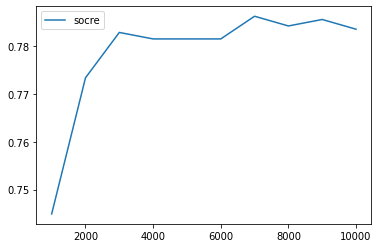

In [19]:
#正解率の変化
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

candidate = list(range(1000, 11000, 1000))
clf = LogisticRegression()
scores = []
for max_features in candidate:
    tp = TextPreprocessing(max_features=max_features)
    bag = tp.get_matrix(train_df.text)
    train_X = bag.toarray()
    train_y = pd.Series(train_df.label)
    clf.fit(lil_matrix(train_X), train_y)

    bag_test = tp.get_matrix(test_df.text, mode='test')
    test_X = bag_test.toarray()
    test_y = pd.Series(test_df.label)
    scores.append(clf.score(lil_matrix(test_X), test_y))

plt.plot(candidate, scores, label='socre')
plt.legend()

In [26]:
#評価
#上のグラフから7500あたりが頭打ちになっていることがわかるのでmax_featuresに7500を代入
%%time
# 学習データに対する前処理
tp = TextPreprocessing(max_features=7500)
bag = tp.get_matrix(train_df.text)
train_X = bag.toarray()
train_y = pd.Series(train_df.label)

CPU times: user 808 ms, sys: 20.5 ms, total: 828 ms
Wall time: 870 ms


In [27]:
#評価
%%time
# 学習時間
from scipy.sparse import lil_matrix
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(lil_matrix(train_X), train_y)

CPU times: user 2.45 s, sys: 3 s, total: 5.46 s
Wall time: 3.71 s


In [28]:
#評価
# 正解率
bag_test = tp.get_matrix(test_df.text, mode='test')
test_X = bag_test.toarray()
test_y = pd.Series(test_df.label)
score = clf.score(lil_matrix(test_X), test_y)
print(score)

0.7849389416553596


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


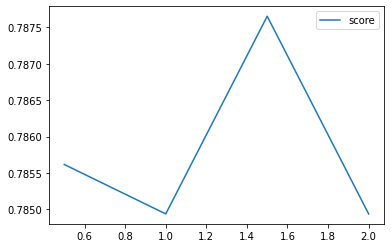

In [29]:
#ハイパーパラメータのチューニング
import matplotlib.pyplot as plt

C_candidate = [0.5, 1.0, 1.5, 2.0]
scores = []
train_X=lil_matrix(train_X)
test_X=lil_matrix(test_X)

for c in C_candidate:
    clf = LogisticRegression(C=c)
    clf.fit(train_X, train_y)
    scores.append(clf.score(test_X, test_y))

plt.plot(C_candidate, scores, label='score')
plt.legend()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


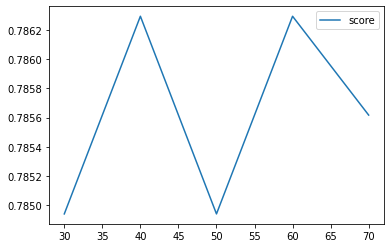

In [31]:
#ハイパーパラメータのチューニング
import matplotlib.pyplot as plt

iter_candidate = [30, 40, 50, 60, 70]
scores = []
train_X=lil_matrix(train_X)
test_X=lil_matrix(test_X)

for iter in iter_candidate:
    clf = LogisticRegression(max_iter=iter)
    clf.fit(train_X, train_y)
    scores.append(clf.score(test_X, test_y))

plt.plot(iter_candidate, scores, label='score')
plt.legend()

In [33]:
#グリッドサーチによるチューニング
import itertools
import warnings

warnings.simplefilter('ignore')
train_X=lil_matrix(train_X)
test_X=lil_matrix(test_X)

# グリッドサーチによるパラメーター探索を実装した関数
def search_best_param(grid_param,  estimator, verbose=False):
    best_acc = 0
    best_param = {}
    product = [x for x in itertools.product(*grid_param.values())]
    params = [dict(zip(grid_param.keys(), r)) for r in product]
    for param in params:
        estimator.set_params(**param)
        estimator.fit(train_X, train_y)
        acc = clf.score(test_X, test_y)
        if verbose:
            print(param, acc)
        if  acc > best_acc:
            best_acc = acc
            best_param = param
    return best_param, best_acc

candidate = []
# 探索するパラメーターの組み合わせ
grid_param = {
    "C": [1.3, 1.4, 1.5, 1.6, 1.7],
    "max_iter": [35, 40, 45]
    }
clf = LogisticRegression()
candidate.append(search_best_param(grid_param, clf))

best_param, best_score = sorted(candidate, key=lambda x: x[1], reverse=True)[0]
print(best_param, best_score) # 最大スコアを出したパラメーターとスコア

{'C': 1.4, 'max_iter': 40} 0.7896879240162822


In [34]:
#評価
%%time
# 学習時間
from scipy.sparse import lil_matrix
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(**best_param) ## グリッドサーチで選択したベストパラムを指定
clf.fit(lil_matrix(train_X), train_y)

CPU times: user 849 ms, sys: 1.01 s, total: 1.86 s
Wall time: 1 s


In [35]:
#評価
# 正解率
bag_test = tp.get_matrix(test_df.text, mode='test')
test_X = bag_test.toarray()
test_y = pd.Series(test_df.label)
score = clf.score(lil_matrix(test_X), test_y)
print(score)

0.7896879240162822
